## **Set 4 (HD Tasks) Investigating Neural Collapse in Deep Learning**

In this research task, you will explore the phenomenon of "neural collapse" in deep learning models. Additionally, you must identify meaningful research gaps or failure cases that arise from the literature or your own experiments.


### Task 4.1 Examine layer rotation with Layca

1. Reproduce experiments described in the paper [Layer rotation: a surprisingly powerful indicator of generalization in deep networks?](https://arxiv.org/abs/1806.01603),  Compare the results you obtained with the ones in the paper. Do you identify any discrepancies?

2. What connections do you discover between the paper and what you have learnt in the unit?



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# setup and utilities
import math, os, json, time, random
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Reproducibility
SEED = 224609189
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

#  accuracy
@torch.no_grad()
def accuracy(top1_logits: torch.Tensor, targets: torch.Tensor) -> float:
    preds = top1_logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

# helper: cosine distance
def cosine_distance(u: torch.Tensor, v: torch.Tensor, eps: float = 1e-12) -> float:
    u = u.view(-1).float(); v = v.view(-1).float()
    num = torch.dot(u, v)
    denom = (u.norm(p=2) * v.norm(p=2)).clamp_min(eps)
    cos_sim = (num / denom).clamp(-1.0, 1.0)
    return float(1.0 - cos_sim)  # distance = 1 - cosine similarity

Device: cuda


In [2]:
# CIFAR-10 Dataloaders
data_root = "/content/drive/MyDrive/cifar-10-batches-py"

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tfms)
test_set  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

NUM_CLASSES = 10

100%|██████████| 170M/170M [00:04<00:00, 36.6MB/s]


In [3]:
# Simple VGG-style CNN (clean and smooth or fast)
class TinyVGG(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            # block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8

            # block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512), nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def build_model():
    model = TinyVGG(NUM_CLASSES).to(DEVICE)
    return model

In [4]:
# Layer lists & rotation snapshots
def list_multiplicative_params(model: nn.Module) -> List[Tuple[str, nn.Parameter]]:
    keep = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            keep.append((f"{name}.weight", module.weight))
    return keep

def snapshot_initial_weights(model: nn.Module) -> Dict[str, torch.Tensor]:
    init = {}
    for name, p in list_multiplicative_params(model):
        init[name] = p.detach().clone().float().cpu()
    return init

@torch.no_grad()
def compute_layer_rotations(model: nn.Module, init_snap: Dict[str, torch.Tensor]) -> Dict[str, float]:
    dists = {}
    for name, p in list_multiplicative_params(model):
        now = p.detach().float().cpu()
        dists[name] = cosine_distance(now, init_snap[name])
    return dists

### Layca (layer-level controlled rotation) – a practical PyTorch version
This minimal version mirrors the algorithmic spirit:
  - project step onto the space orthogonal to current weights,
  - normalize step to have the same L2 norm as the weight tensor,
  - update with layer-wise learning rate ρ_l(t),
  - optionally re-project weight norm to the initial norm (sphere projection).    

In [5]:
# Layca controller
# REDEFINE LaycaController (run this cell, then rerun your training)
class LaycaController:
    def __init__(self, model: nn.Module, init_snap: Dict[str, torch.Tensor],
                 base_lr: float = 0.01, alpha: float = 0.0,
                 project_back_to_init_sphere: bool = True):
        self.model = model
        self.init_snap = {k: v.to(next(model.parameters()).device) for k, v in init_snap.items()}
        self.base_lr = base_lr
        self.alpha = alpha
        self.project_back = project_back_to_init_sphere

        # cache order & α multipliers
        self.layer_order = [n for n, _ in list_multiplicative_params(model)]
        L = max(len(self.layer_order), 1)
        self.multipliers = {}
        for l, name in enumerate(self.layer_order):
            if alpha > 0:
                mult = ((1 - alpha) ** 5) ** ((L-1-l) / (L-1 if L>1 else 1))
            else:
                mult = ((1 + alpha) ** 5) ** (l / (L-1 if L>1 else 1))
            self.multipliers[name] = float(mult)

        # IDs of conv/linear weight Parameters to skip in the “other params” loop
        self.mul_param_ids = {id(p) for _, p in list_multiplicative_params(self.model)}

    @torch.no_grad()
    def step(self):
        # rotation-controlled updates for conv/linear weights
        for name, p in list_multiplicative_params(self.model):
            if p.grad is None:
                continue
            w = p.data
            g = p.grad.data
            s = -g
            ww = (w * w).sum()
            if ww > 0:
                coeff = (s * w).sum() / ww
                s = s - coeff * w
            s_norm = s.norm(p=2)
            w_norm = w.norm(p=2)
            if s_norm > 0:
                s = s * (w_norm / s_norm)
            rho = self.base_lr * self.multipliers[name]
            w.add_(rho * s)
            if self.project_back:
                w0_norm = self.init_snap[name].norm(p=2).to(w.device)
                new_norm = w.norm(p=2).clamp_min(1e-12)
                w.mul_(w0_norm / new_norm)

        # tiny SGD step for biases/BN only (skip conv/linear weights using IDs)
        for p in self.model.parameters():
            if p.grad is None or id(p) in self.mul_param_ids:
                continue
            p.data.add_(-self.base_lr * p.grad.data)

In [6]:
# Train/eval + regimes
def eval_epoch(model, loader, loss_fn):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss_sum += float(loss.item()) * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
    return loss_sum / total, correct / total

def train_one_epoch_standard(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item()) * x.size(0)
    return total_loss / len(loader.dataset)

def train_one_epoch_layca(model, loader, controller: LaycaController, loss_fn):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        for p in model.parameters():  # clear grads
            if p.grad is not None: p.grad = None
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        controller.step()
        total_loss += float(loss.item()) * x.size(0)
    return total_loss / len(loader.dataset)

def run_regime(regime: str, epochs: int = 40, base_lr: float = 0.03,
               weight_decay: float = 5e-4, alpha: float = 0.0,
               decay_milestones=(30, 37), decay_gamma=0.2):
    """
    regime ∈ {'sgd', 'sgd_wd', 'adam', 'rmsprop', 'layca'}
    """
    model = build_model()
    loss_fn = nn.CrossEntropyLoss()

    # snapshot initial multiplicative weights for rotation curves
    init_snap = snapshot_initial_weights(model)

    # choose optimizer/controller
    if regime == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, nesterov=True)
    elif regime == "sgd_wd":
        optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif regime == "adam":
        optimizer = optim.Adam(model.parameters(), lr=base_lr)
    elif regime == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=base_lr, momentum=0.9)
    elif regime == "layca":
        controller = LaycaController(model, init_snap, base_lr=base_lr, alpha=alpha, project_back_to_init_sphere=True)
        optimizer = None
    else:
        raise ValueError("Unknown regime")

    # LR schedule (simple multi-step)
    if optimizer is not None:
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(decay_milestones), gamma=decay_gamma)

    history = {
        "regime": regime,
        "epochs": epochs,
        "base_lr": base_lr,
        "alpha": alpha,
        "weight_decay": weight_decay if regime == "sgd_wd" else 0.0,
        "train_loss": [],
        "test_loss": [],
        "test_acc": [],
        "rotation_curves": [],   # list[ {layer_name: dist, ...} ] per epoch
    }

    for ep in range(1, epochs+1):
        if regime == "layca":
            tr_loss = train_one_epoch_layca(model, train_loader, controller, loss_fn)
        else:
            tr_loss = train_one_epoch_standard(model, train_loader, optimizer, loss_fn)
            scheduler.step()

        te_loss, te_acc = eval_epoch(model, test_loader, loss_fn)
        rots = compute_layer_rotations(model, init_snap)

        history["train_loss"].append(tr_loss)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)
        history["rotation_curves"].append(rots)

        lr_now = controller.base_lr if regime == "layca" else scheduler.get_last_lr()[0]
        print(f"[{regime}] epoch {ep:03d}/{epochs} | lr={lr_now:.5f} | "
              f"train_loss={tr_loss:.4f} | test_acc={te_acc*100:.2f}%")

    return model, history

In [7]:
# Quick sanity run

EPOCHS = 8  # start small for a smoke test; later try 40–100
configs = [
    ("sgd",      dict(base_lr=0.03)),
    ("sgd_wd",   dict(base_lr=0.03, weight_decay=5e-4)),
    ("adam",     dict(base_lr=0.001)),
    ("rmsprop",  dict(base_lr=0.001)),
    ("layca",    dict(base_lr=0.03, alpha=0.0)),   # α=0 → uniform rotation across layers
]

all_histories = {}
for name, kw in configs:
    _, hist = run_regime(name, epochs=EPOCHS, **kw)
    all_histories[name] = hist

# Save logs
os.makedirs("runs_layer_rotation", exist_ok=True)
with open("runs_layer_rotation/histories.json", "w") as f:
    json.dump(all_histories, f)
print("Saved logs to runs_layer_rotation/histories.json")

[sgd] epoch 001/8 | lr=0.03000 | train_loss=1.3487 | test_acc=63.12%
[sgd] epoch 002/8 | lr=0.03000 | train_loss=0.9117 | test_acc=61.58%
[sgd] epoch 003/8 | lr=0.03000 | train_loss=0.7510 | test_acc=72.16%
[sgd] epoch 004/8 | lr=0.03000 | train_loss=0.6470 | test_acc=76.60%
[sgd] epoch 005/8 | lr=0.03000 | train_loss=0.5761 | test_acc=78.68%
[sgd] epoch 006/8 | lr=0.03000 | train_loss=0.5193 | test_acc=79.25%
[sgd] epoch 007/8 | lr=0.03000 | train_loss=0.4722 | test_acc=80.29%
[sgd] epoch 008/8 | lr=0.03000 | train_loss=0.4304 | test_acc=80.97%
[sgd_wd] epoch 001/8 | lr=0.03000 | train_loss=1.3425 | test_acc=56.12%
[sgd_wd] epoch 002/8 | lr=0.03000 | train_loss=0.8807 | test_acc=68.11%
[sgd_wd] epoch 003/8 | lr=0.03000 | train_loss=0.7202 | test_acc=70.29%
[sgd_wd] epoch 004/8 | lr=0.03000 | train_loss=0.6233 | test_acc=77.22%
[sgd_wd] epoch 005/8 | lr=0.03000 | train_loss=0.5575 | test_acc=78.21%
[sgd_wd] epoch 006/8 | lr=0.03000 | train_loss=0.4985 | test_acc=78.91%
[sgd_wd] epoch 0

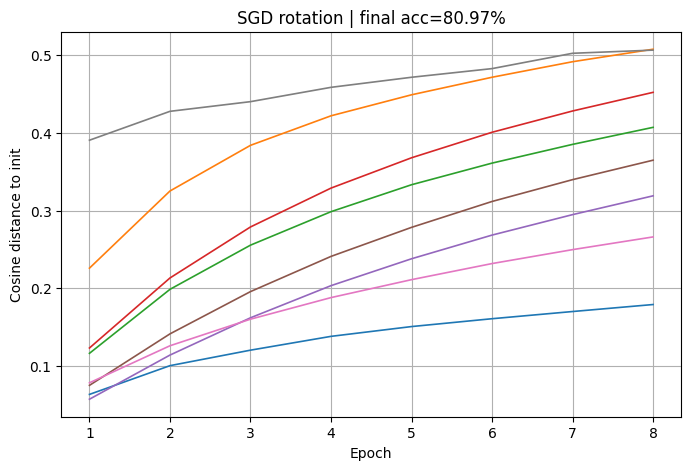

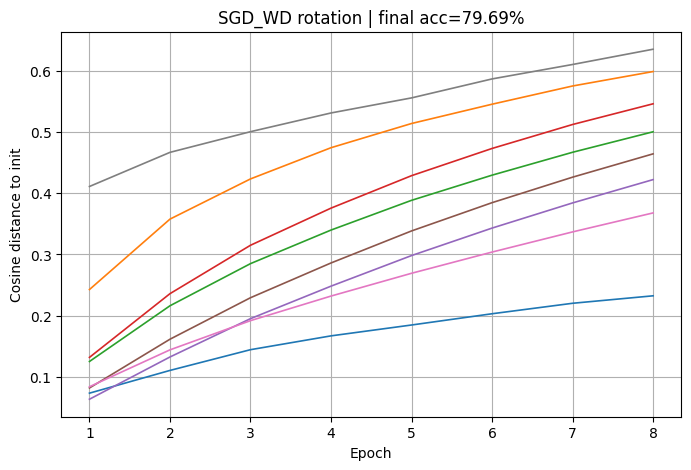

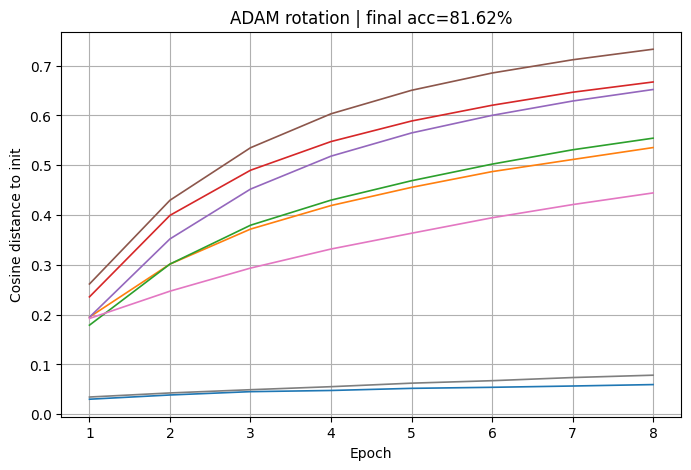

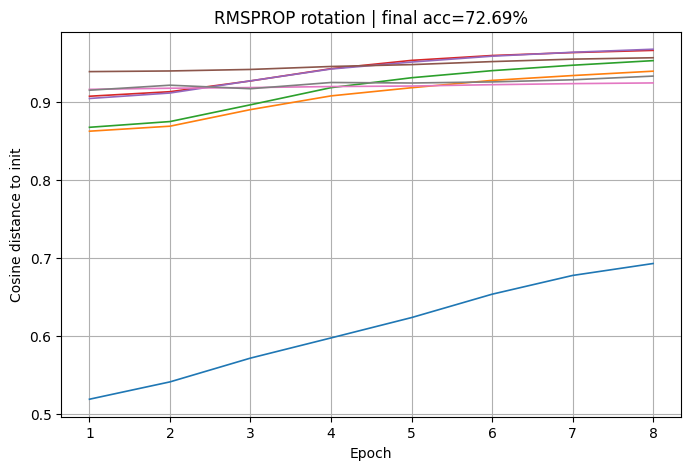

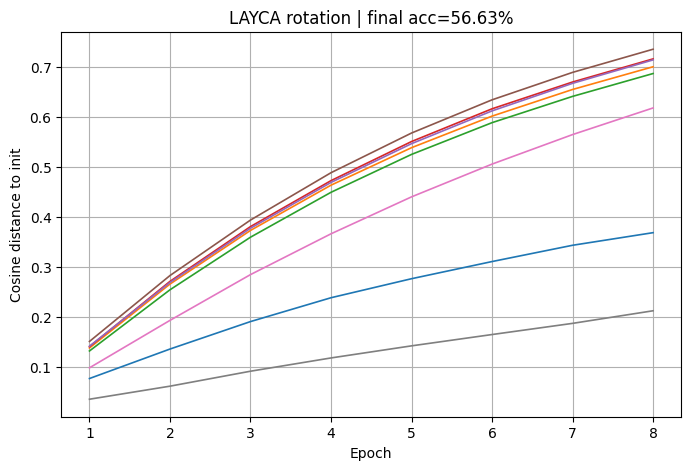

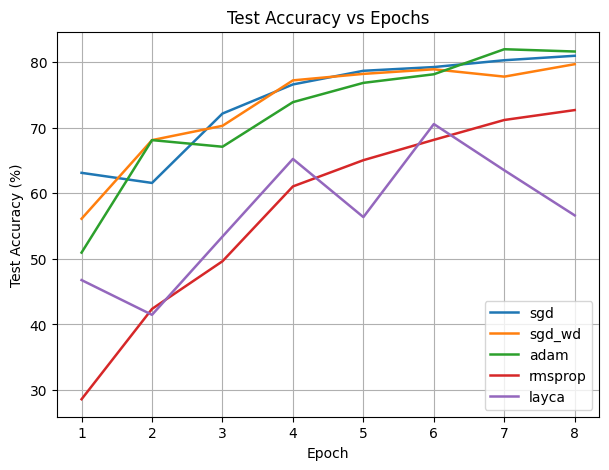

In [8]:
import matplotlib.pyplot as plt

def plot_rotation_curves(history, title="rotation curves"):
    layers = list(history["rotation_curves"][0].keys())
    xs = list(range(1, len(history["rotation_curves"])+1))
    plt.figure(figsize=(8,5))
    for lname in layers:
        ys = [ep[lname] for ep in history["rotation_curves"]]
        plt.plot(xs, ys, linewidth=1.2)
    plt.xlabel("Epoch"); plt.ylabel("Cosine distance to init")
    plt.title(title + f" | final acc={history['test_acc'][-1]*100:.2f}%")
    plt.grid(True); plt.show()

def plot_acc_curves(histories: Dict[str, Dict]):
    plt.figure(figsize=(7,5))
    for k, h in histories.items():
        plt.plot(range(1, len(h["test_acc"])+1),
                 [a*100 for a in h["test_acc"]],
                 label=k, linewidth=1.8)
    plt.xlabel("Epoch"); plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy vs Epochs")
    plt.grid(True); plt.legend(); plt.show()

# example usage:
for name, h in all_histories.items():
    plot_rotation_curves(h, title=f"{name.upper()} rotation")
plot_acc_curves(all_histories)

In [9]:
# SGD learning-rate sweep

import json, os

# choose the exact LR set you want (mirrors the paper: 3**-4 ... 3**0)
LR_LIST = [3**-4, 3**-3, 3**-2, 3**-1, 3**0]   # ≈ [0.0123, 0.037, 0.111, 0.333, 1.0]
EPOCHS_SWEEP = 40  # paper-style curves look nicer with ≥40; you can lower for quick tests

sgd_lr_histories = {}
for lr in LR_LIST:
    tag = f"sgd_lr={lr:.5f}"
    print(f"\n=== Running {tag} ===")
    _, h = run_regime(
        regime="sgd",
        epochs=EPOCHS_SWEEP,
        base_lr=lr,
        decay_milestones=(int(EPOCHS_SWEEP*0.75), int(EPOCHS_SWEEP*0.9)),  # simple schedule
        decay_gamma=0.2
    )
    sgd_lr_histories[tag] = h

os.makedirs("runs_layer_rotation", exist_ok=True)
with open("runs_layer_rotation/sgd_lr_histories.json", "w") as f:
    json.dump(sgd_lr_histories, f)
print("Saved to runs_layer_rotation/sgd_lr_histories.json")



=== Running sgd_lr=0.01235 ===
[sgd] epoch 001/40 | lr=0.01235 | train_loss=1.2484 | test_acc=64.72%
[sgd] epoch 002/40 | lr=0.01235 | train_loss=0.8135 | test_acc=67.27%
[sgd] epoch 003/40 | lr=0.01235 | train_loss=0.6710 | test_acc=76.28%
[sgd] epoch 004/40 | lr=0.01235 | train_loss=0.5840 | test_acc=75.85%
[sgd] epoch 005/40 | lr=0.01235 | train_loss=0.5248 | test_acc=77.42%
[sgd] epoch 006/40 | lr=0.01235 | train_loss=0.4754 | test_acc=79.03%
[sgd] epoch 007/40 | lr=0.01235 | train_loss=0.4389 | test_acc=82.48%
[sgd] epoch 008/40 | lr=0.01235 | train_loss=0.4057 | test_acc=80.88%
[sgd] epoch 009/40 | lr=0.01235 | train_loss=0.3760 | test_acc=80.78%
[sgd] epoch 010/40 | lr=0.01235 | train_loss=0.3519 | test_acc=84.66%
[sgd] epoch 011/40 | lr=0.01235 | train_loss=0.3342 | test_acc=81.90%
[sgd] epoch 012/40 | lr=0.01235 | train_loss=0.3112 | test_acc=86.48%
[sgd] epoch 013/40 | lr=0.01235 | train_loss=0.2904 | test_acc=85.76%
[sgd] epoch 014/40 | lr=0.01235 | train_loss=0.2727 | test

/tmp/ipython-input-2701727457.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


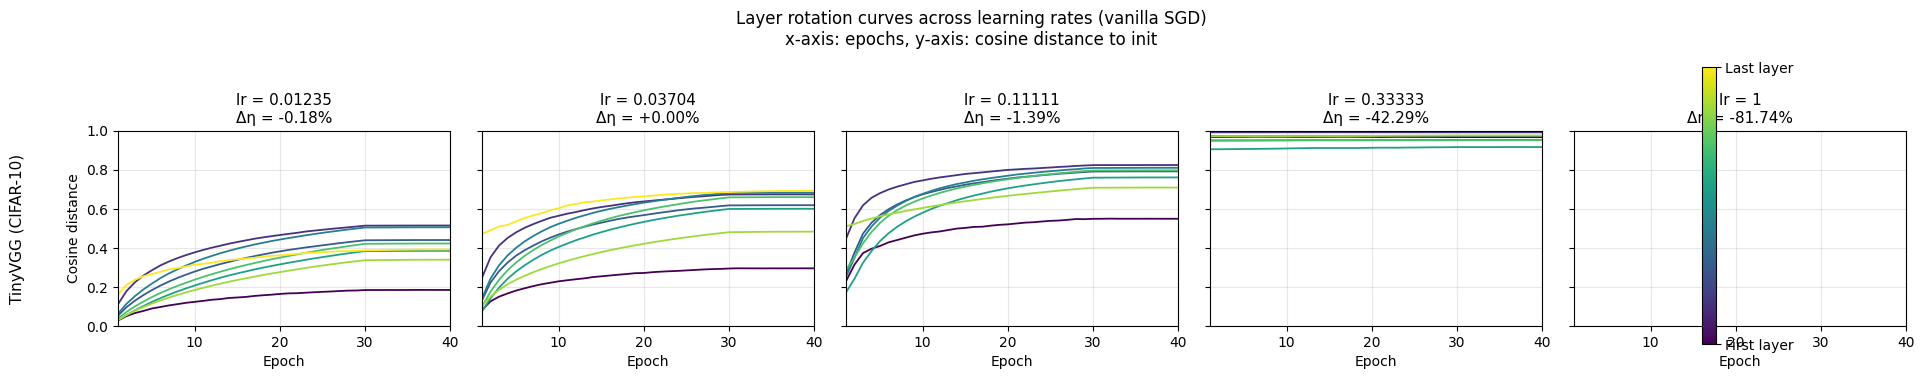

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def _ordered_layers_from_history(history):
    # keep layer order consistent across epochs
    return list(history["rotation_curves"][0].keys())

def _final_acc(history):
    return float(history["test_acc"][-1]) * 100.0

def plot_lr_grid(histories_by_lr: dict, title_left="TinyVGG (CIFAR-10)"):
    """
    histories_by_lr: dict with keys like 'sgd_lr=0.03704' -> history dict
    Draws 1 row, N columns; each panel = rotation curves for that LR.
    Colors encode layer depth (first→last).
    """
    # sort columns by numeric LR
    items = []
    for k, h in histories_by_lr.items():
        # extract numeric LR from key 'sgd_lr=...'
        lr_val = float(k.split("=")[1])
        items.append((lr_val, k, h))
    items.sort(key=lambda x: x[0])

    # compute best accuracy for Δη
    best_acc = max(_final_acc(h) for _,_,h in items)

    ncols = len(items)
    fig, axes = plt.subplots(1, ncols, figsize=(3.8*ncols, 3.6), sharey=True)

    # if ncols==1, axes is not a list
    if ncols == 1:
        axes = [axes]

    # color per layer (first→last)
    layers = _ordered_layers_from_history(items[0][2])
    L = len(layers)
    cmap = plt.cm.viridis
    layer_colors = {lname: cmap(i/(max(L-1,1))) for i, lname in enumerate(layers)}

    for ax, (lr, key, hist) in zip(axes, items):
        xs = np.arange(1, len(hist["rotation_curves"])+1)
        for lname in layers:
            ys = [ep[lname] for ep in hist["rotation_curves"]]
            ax.plot(xs, ys, lw=1.3, color=layer_colors[lname])
        ax.set_xlim(1, xs[-1])
        ax.set_ylim(0.0, 1.0)
        ax.grid(True, alpha=0.3)
        acc = _final_acc(hist)
        delta = acc - best_acc
        ax.set_title(f"lr = {lr:g}\nΔη = {delta:+.2f}%", fontsize=11)
        if ax is axes[0]:
            ax.set_ylabel("Cosine distance")
            ax.text(-0.28, 0.5, title_left, va="center", ha="right",
                    rotation=90, transform=ax.transAxes, fontsize=11)
        ax.set_xlabel("Epoch")

    # little legend-like colorbar indicating “first ↔ last layer”
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=L-1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.04)
    cbar.set_ticks([0, L-1])
    cbar.set_ticklabels(["First layer", "Last layer"])

    fig.suptitle("Layer rotation curves across learning rates (vanilla SGD)\n" +
                 "x-axis: epochs, y-axis: cosine distance to init", y=1.04, fontsize=12)
    plt.tight_layout()
    plt.show()

# draw the grid
plot_lr_grid(sgd_lr_histories)

In [11]:
# Run SGD+WD sweep (same LRs)
sgdwd_lr_histories = {}
for lr in LR_LIST:
    tag = f"sgdwd_lr={lr:.5f}"
    print(f"\n=== Running {tag} ===")
    _, h = run_regime(
        regime="sgd_wd",
        epochs=EPOCHS_SWEEP,
        base_lr=lr,
        weight_decay=5e-4,
        decay_milestones=(int(EPOCHS_SWEEP*0.75), int(EPOCHS_SWEEP*0.9)),
        decay_gamma=0.2
    )
    sgdwd_lr_histories[tag] = h



=== Running sgdwd_lr=0.01235 ===
[sgd_wd] epoch 001/40 | lr=0.01235 | train_loss=1.2487 | test_acc=63.87%
[sgd_wd] epoch 002/40 | lr=0.01235 | train_loss=0.8076 | test_acc=66.00%
[sgd_wd] epoch 003/40 | lr=0.01235 | train_loss=0.6680 | test_acc=75.27%
[sgd_wd] epoch 004/40 | lr=0.01235 | train_loss=0.5823 | test_acc=79.73%
[sgd_wd] epoch 005/40 | lr=0.01235 | train_loss=0.5159 | test_acc=78.79%
[sgd_wd] epoch 006/40 | lr=0.01235 | train_loss=0.4722 | test_acc=80.38%
[sgd_wd] epoch 007/40 | lr=0.01235 | train_loss=0.4345 | test_acc=78.45%
[sgd_wd] epoch 008/40 | lr=0.01235 | train_loss=0.4016 | test_acc=83.54%
[sgd_wd] epoch 009/40 | lr=0.01235 | train_loss=0.3764 | test_acc=77.02%
[sgd_wd] epoch 010/40 | lr=0.01235 | train_loss=0.3477 | test_acc=80.28%
[sgd_wd] epoch 011/40 | lr=0.01235 | train_loss=0.3253 | test_acc=83.85%
[sgd_wd] epoch 012/40 | lr=0.01235 | train_loss=0.3091 | test_acc=83.94%
[sgd_wd] epoch 013/40 | lr=0.01235 | train_loss=0.2905 | test_acc=84.55%
[sgd_wd] epoch 01

/tmp/ipython-input-1981646260.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


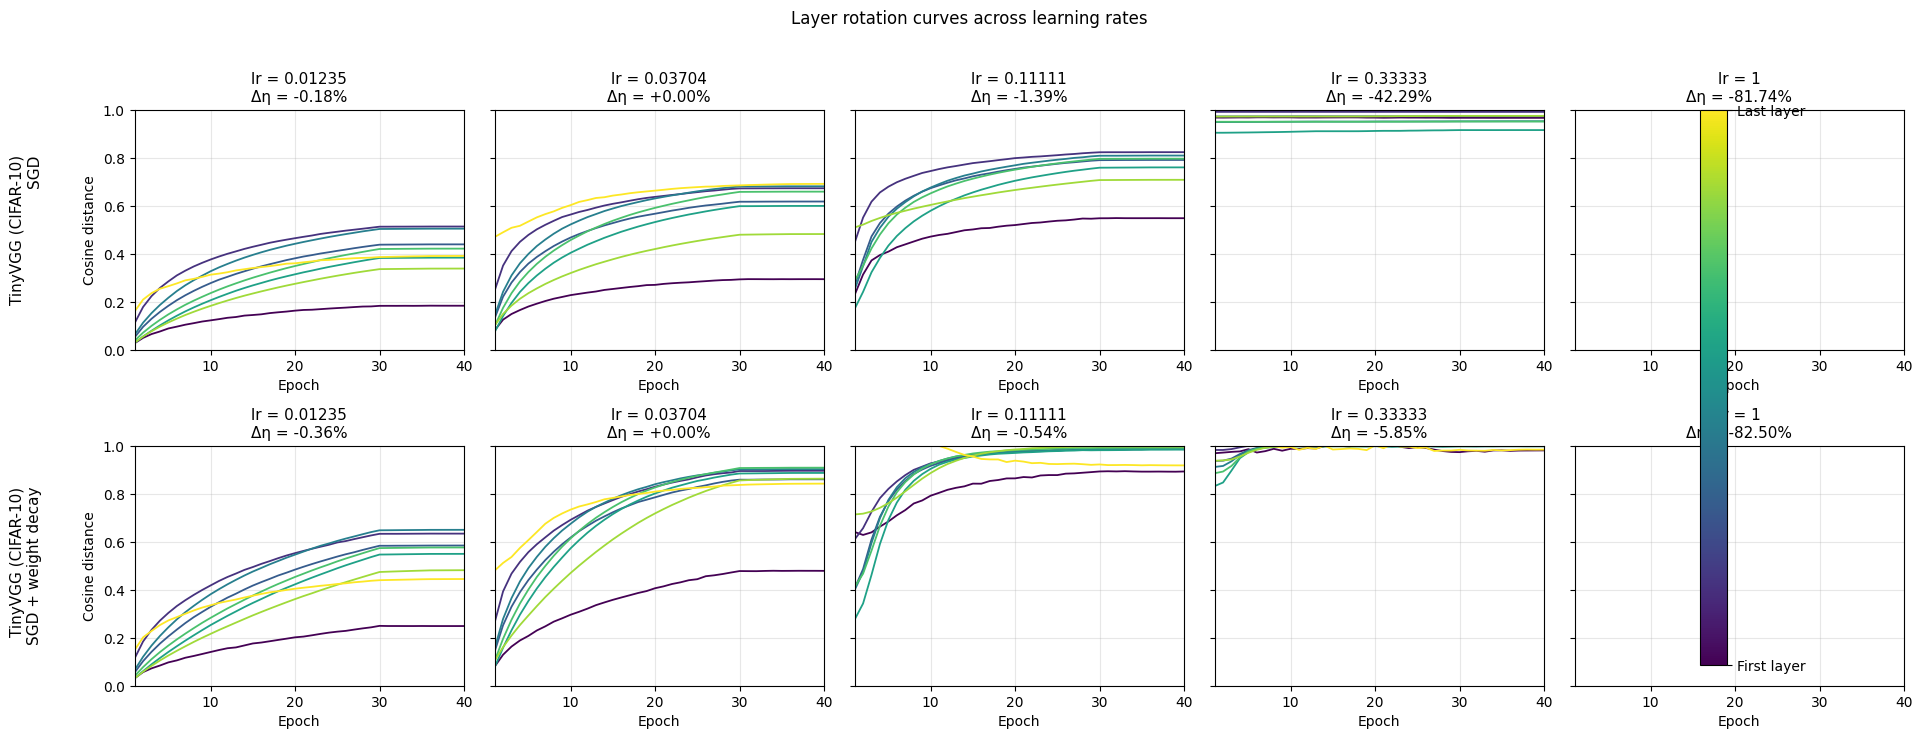

In [13]:
def plot_two_rows_grid(row1_hist: dict, row2_hist: dict,
                       row1_title="SGD", row2_title="SGD + weight decay",
                       left_label="TinyVGG (CIFAR-10)"):
    # sort columns by LR
    def sort_items(hmap):
        outs = []
        for k,h in hmap.items():
            lr_val = float(k.split("=")[1])
            outs.append((lr_val,k,h))
        return sorted(outs, key=lambda x:x[0])

    items1 = sort_items(row1_hist)
    items2 = sort_items(row2_hist)
    assert len(items1) == len(items2), "Need same LR grid for both rows"

    ncols = len(items1)
    fig, axes = plt.subplots(2, ncols, figsize=(3.8*ncols, 7.2), sharey=True)

    # color mapping shared across rows
    layers = list(items1[0][2]["rotation_curves"][0].keys())
    L = len(layers); cmap = plt.cm.viridis
    layer_colors = {lname: cmap(i/(max(L-1,1))) for i, lname in enumerate(layers)}

    # helper to draw a row
    def draw_row(ax_row, items, label_left):
        best_acc = max(float(h["test_acc"][-1])*100 for _,_,h in items)
        for ax, (lr, key, hist) in zip(ax_row, items):
            xs = np.arange(1, len(hist["rotation_curves"])+1)
            for lname in layers:
                ys = [ep[lname] for ep in hist["rotation_curves"]]
                ax.plot(xs, ys, lw=1.3, color=layer_colors[lname])
            ax.set_xlim(1, xs[-1]); ax.set_ylim(0.0, 1.0); ax.grid(True, alpha=0.3)
            acc = float(hist["test_acc"][-1])*100
            delta = acc - best_acc
            ax.set_title(f"lr = {lr:g}\nΔη = {delta:+.2f}%", fontsize=11)
            if ax is ax_row[0]:
                ax.set_ylabel("Cosine distance")
                ax.text(-0.28, 0.5, label_left, va="center", ha="right",
                        rotation=90, transform=ax.transAxes, fontsize=11)
            ax.set_xlabel("Epoch")

    draw_row(axes[0], items1, f"{left_label}\n{row1_title}")
    draw_row(axes[1], items2, f"{left_label}\n{row2_title}")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=L-1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.02, pad=0.02)
    cbar.set_ticks([0, L-1]); cbar.set_ticklabels(["First layer", "Last layer"])

    fig.suptitle("Layer rotation curves across learning rates", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# draw the two-row grid
plot_two_rows_grid(sgd_lr_histories, sgdwd_lr_histories)


### Task 4.2 Design and Develop Your Own ML Solution
1. Design and develop your own deep learning solution using CIFAR dataset. The proposed solution must be substantially different from the approaches presented in the article. However, this does not mean you are required to choose a new ML algorithm. You can develop a novel solution by changing the feature
selection approach, using different preprocessing techniques, exploring alternative model combinations, or restructuring the training pipeline. The goal is to propose a system that is meaningfully distinct from the authors' method.
Your technical report must include:
* A clear motivation for the proposed solution
* A description of how your method differs from the article
* A well-structured experimental protocol
* Evaluation using Accuracy, Precision, Recall, F1 Score, and AUC.

In [12]:
# import necessary libraries
import os, math, random, json
from typing import Dict, Tuple
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [15]:
# Setup / simple configuration
seed = 224609189
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

CFG = {
    "dataset": "CIFAR10",                # "CIFAR10" or "CIFAR100"
    "data_root": "/content/drive/MyDrive/cifar-10-batches-py",       # <-- put your local absolute path here
    "epochs": 60,                        # bump to 200 for final runs
    "batch": 128,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    # augmentation knobs
    "mixup_alpha": 0.4,                  # set 0.0 to disable
    "cutmix_alpha": 1.0,                 # set 0.0 to disable
    # rotation-regularization (our novelty)
    "use_rotation_reg": True,
    "rot_target": 0.95,                  # push mean layer rotation toward this
    "lam_rot": 0.3,                      # try {0.0, 0.1, 0.3}
    "rot_warmup_epochs": 5,              # start without penalty, then enable
    # label smoothing (optional)
    "label_smoothing": 0.0,
    # logging
    "out_dir": "./run_logs"
}
os.makedirs(CFG["out_dir"], exist_ok=True)

Device: cuda


In [17]:
# data + basic transformation
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_tfms = transforms.Compose([transforms.ToTensor()])

if CFG["dataset"].upper() == "CIFAR10":
    train_set = datasets.CIFAR10(CFG["data_root"], train=True, download=True, transform=train_tfms)
    test_set  = datasets.CIFAR10(CFG["data_root"], train=False, download=True, transform=test_tfms)
    NUM_CLASSES = 10
else:
    train_set = datasets.CIFAR100(CFG["data_root"], train=True, download=True, transform=train_tfms)
    test_set  = datasets.CIFAR100(CFG["data_root"], train=False, download=True, transform=test_tfms)
    NUM_CLASSES = 100

train_loader = DataLoader(train_set, batch_size=CFG["batch"], shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=256,         shuffle=False, num_workers=2, pin_memory=True)


In [18]:
# Model: Small ResNet-ish + SE
class SEBlock(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(c, c//r, 1), nn.ReLU(inplace=True),
            nn.Conv2d(c//r, c, 1), nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x)
        return x * w

class SmallResNet(nn.Module):
    """
    Tiny, friendly model for CIFAR.
    Two conv stages + optional SE before pooling.
    """
    def __init__(self, num_classes=10, use_se=True):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(256)
        self.se    = SEBlock(256) if use_se else nn.Identity()
        self.pool  = nn.AdaptiveAvgPool2d(1)
        self.fc    = nn.Linear(256, num_classes)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.se(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

In [34]:
# MixUp / CutMix utils
def _rand_bbox(W, H, lam):
    cut_rat = (1. - lam) ** 0.5
    cw, ch = int(W*cut_rat), int(H*cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = np.clip(cx - cw//2, 0, W), np.clip(cy - ch//2, 0, H)
    x2, y2 = np.clip(cx + cw//2, 0, W), np.clip(cy + ch//2, 0, H)
    return x1, y1, x2, y2

def mixup_cutmix(x, y, mixup_alpha, cutmix_alpha):
    """
    Returns:
      x_aug, y_a, y_b, lam (float), mode in {"none","mixup","cutmix"}
    """
    mode = "none"
    lam = 1.0
    y_b = y

    if cutmix_alpha > 0.0 and np.random.rand() < 0.5:
        # --- CutMix ---
        lam_sample = np.random.beta(cutmix_alpha, cutmix_alpha)
        bx1, by1, bx2, by2 = _rand_bbox(x.size(-1), x.size(-2), lam_sample)

        idx = torch.randperm(x.size(0), device=x.device)
        x[:, :, by1:by2, bx1:bx2] = x[idx, :, by1:by2, bx1:bx2]

        # compute area-based lambda BEFORE assigning label permutation
        patch_area = (bx2 - bx1) * (by2 - by1)
        img_area = x.size(-1) * x.size(-2)
        lam = 1.0 - patch_area / float(img_area)

        y_b = y[idx]
        mode = "cutmix"

    elif mixup_alpha > 0.0:
        # --- MixUp ---
        lam_sample = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(x.size(0), device=x.device)
        x = lam_sample * x + (1.0 - lam_sample) * x[idx]
        y_b = y[idx]
        lam = float(lam_sample)
        mode = "mixup"

    return x, y, y_b, float(lam), mode

In [45]:
# Rotation helpers (novel solution)
def snapshot_init_weights(model: nn.Module):
    """Take an init snapshot on the SAME device; treat as a constant (no grad)."""
    snap = {}
    for n, p in model.named_parameters():
        if "weight" in n:
            snap[n] = p.detach().clone().to(device)   # constant baseline
    return snap

def cosine_distance(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """1 - cosine similarity, differentiable w.r.t. 'a'."""
    a = a.view(-1).float()
    b = b.view(-1).float()
    dot = torch.dot(a, b)
    denom = (a.norm() * b.norm()).clamp_min(eps)
    cos = (dot / denom).clamp(-1.0, 1.0)
    return 1.0 - cos

def rotation_loss(model: nn.Module, init_snap, target: float = 0.95) -> torch.Tensor:
    """
    Penalize being below the target rotation: mean(ReLU(target - rot_l)).
    No detach on current weights so gradients flow.
    """
    terms = []
    for n, p in model.named_parameters():
        if "weight" in n:
            rot = cosine_distance(p, init_snap[n])  # p is live; init is constant
            terms.append(F.relu(torch.tensor(target, device=p.device) - rot))
    if not terms:
        return torch.tensor(0.0, device=device)
    return torch.stack(terms).mean()

def rotation_distances(model: nn.Module, init_snap) -> Dict[str, float]:
    """
    Returns a dict {layer_name: cosine_distance_to_init}
    Uses the same cosine_distance() you already defined.
    """
    out = {}
    for n, p in model.named_parameters():
        if "weight" in n:
            out[n] = float(cosine_distance(p, init_snap[n]).detach().cpu())
    return out

In [46]:
# Metrics (Acc, P, R, F1, AUC)
@torch.no_grad()
def eval_full(model: nn.Module, loader: DataLoader, num_classes: int) -> Tuple[float,float,float,float,float]:
    model.eval()
    probs, ytrue = [], []
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        p = F.softmax(logits, dim=1)
        probs.append(p.cpu().numpy()); ytrue.append(y.cpu().numpy())
        correct += (logits.argmax(1) == y).sum().item()
        total   += y.size(0)
    ytrue = np.concatenate(ytrue)
    probs = np.concatenate(probs)
    ypred = probs.argmax(1)
    acc = correct/total
    prec, rec, f1, _ = precision_recall_fscore_support(ytrue, ypred, average="macro", zero_division=0)
    try:
        auc = roc_auc_score(ytrue, probs, multi_class="ovr", average="macro")
    except Exception:
        auc = float("nan")
    return acc, prec, rec, f1, auc

In [47]:
# One training function (handles baseline vs ours)
def run_experiment(use_se: bool, use_rotation_reg: bool, tag: str):
    model = SmallResNet(num_classes=NUM_CLASSES, use_se=use_se).to(device)
    init_snap = snapshot_init_weights(model)  # snapshot for rotation tracking
    opt = torch.optim.SGD(
        model.parameters(),
        lr=CFG["lr"],
        momentum=CFG["momentum"],
        weight_decay=CFG["weight_decay"]
    )

    logs = {
        "ep": [], "train_acc": [], "val_acc": [],
        "precision": [], "recall": [], "f1": [], "auc": [],
        "mean_rot": []   # <-- new tracker
    }

    for ep in range(1, CFG["epochs"] + 1):
        model.train()
        tot, ok = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x, y1, y2, lam, mode = mixup_cutmix(x, y, CFG["mixup_alpha"], CFG["cutmix_alpha"])

            opt.zero_grad(set_to_none=True)
            out = model(x)

            # CE (scalar-safe)
            ce1 = F.cross_entropy(out, y1, reduction='mean', label_smoothing=CFG["label_smoothing"])
            if mode != "none":
                ce2 = F.cross_entropy(out, y2, reduction='mean', label_smoothing=CFG["label_smoothing"])
                lam = float(lam)
                ce = lam * ce1 + (1.0 - lam) * ce2
            else:
                ce = ce1

            # rotation penalty (after warm-up)
            rot_pen = torch.tensor(0.0, device=device)
            if use_rotation_reg and ep > CFG["rot_warmup_epochs"]:
                rot_pen = CFG["lam_rot"] * rotation_loss(model, init_snap, target=CFG["rot_target"])

            # total loss
            loss = (ce + rot_pen).mean()
            loss.backward()
            opt.step()

            ok += (out.argmax(1) == y).sum().item()
            tot += y.size(0)

        tr_acc = ok / tot
        va_acc, pr, rc, f1, auc = eval_full(model, test_loader, NUM_CLASSES)

        # --- mean rotation logging ---
        rots = rotation_distances(model, init_snap)
        mean_rot = float(np.mean(list(rots.values()))) if len(rots) > 0 else 0.0

        logs["ep"].append(ep)
        logs["train_acc"].append(tr_acc)
        logs["val_acc"].append(va_acc)
        logs["precision"].append(pr)
        logs["recall"].append(rc)
        logs["f1"].append(f1)
        logs["auc"].append(auc)
        logs["mean_rot"].append(mean_rot)

        if ep <= 5 or ep % 5 == 0:
            print(f"[{tag}] ep {ep:03d}/{CFG['epochs']} "
                  f"train {tr_acc*100:5.2f}% | val {va_acc*100:5.2f}% "
                  f"| F1 {f1:.3f} | AUC {auc:.3f} | meanRot {mean_rot:.3f}")

    # save logs for report
    with open(os.path.join(CFG["out_dir"], f"logs_{tag}.json"), "w") as f:
        json.dump(logs, f)
    return model, logs

In [48]:
# Baseline vs Ours (two runs)
print("\n== Run 1: Baseline (SE off, no rotation regularization) ==")
base_model, base_logs = run_experiment(use_se=False, use_rotation_reg=False, tag=f"{CFG['dataset']}_baseline")

print("\n== Run 2: Ours (SE on, rotation regularization) ==")
rot_model, rot_logs = run_experiment(use_se=True, use_rotation_reg=CFG["use_rotation_reg"], tag=f"{CFG['dataset']}_rotreg")

# quick summary line for your report
def last_metrics(logs: Dict[str, list]) -> Dict[str, float]:
    return {
        "ValAcc":  logs["val_acc"][-1],
        "Precision": logs["precision"][-1],
        "Recall":    logs["recall"][-1],
        "F1":        logs["f1"][-1],
        "AUC":       logs["auc"][-1],
    }

print("\n=== Final snapshot ===")
print("Baseline :", last_metrics(base_logs))
print("Rot+SE   :", last_metrics(rot_logs))
print(f"Logs saved in: {CFG['out_dir']}")


== Run 1: Baseline (SE off, no rotation regularization) ==
[CIFAR10_baseline] ep 001/60 train 24.85% | val 31.57% | F1 0.253 | AUC 0.835 | meanRot 0.023
[CIFAR10_baseline] ep 002/60 train 31.00% | val 26.57% | F1 0.183 | AUC 0.784 | meanRot 0.040
[CIFAR10_baseline] ep 003/60 train 34.14% | val 32.03% | F1 0.236 | AUC 0.859 | meanRot 0.053
[CIFAR10_baseline] ep 004/60 train 34.58% | val 38.32% | F1 0.326 | AUC 0.875 | meanRot 0.065
[CIFAR10_baseline] ep 005/60 train 36.85% | val 48.83% | F1 0.464 | AUC 0.901 | meanRot 0.076
[CIFAR10_baseline] ep 010/60 train 40.01% | val 52.38% | F1 0.496 | AUC 0.911 | meanRot 0.122
[CIFAR10_baseline] ep 015/60 train 41.83% | val 63.17% | F1 0.633 | AUC 0.939 | meanRot 0.160
[CIFAR10_baseline] ep 020/60 train 42.79% | val 60.26% | F1 0.600 | AUC 0.943 | meanRot 0.193
[CIFAR10_baseline] ep 025/60 train 44.80% | val 50.25% | F1 0.478 | AUC 0.917 | meanRot 0.223
[CIFAR10_baseline] ep 030/60 train 44.75% | val 43.84% | F1 0.428 | AUC 0.913 | meanRot 0.247


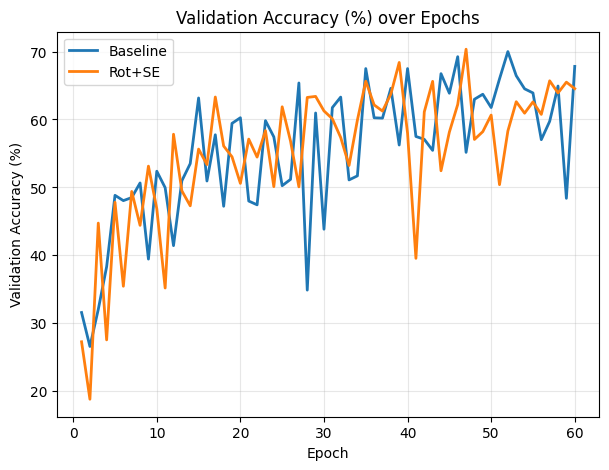

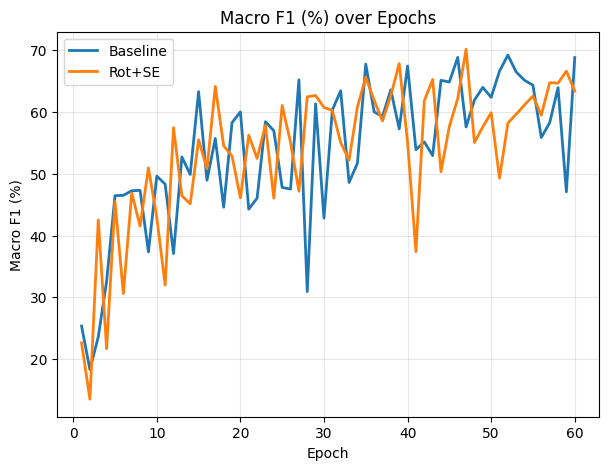

In [49]:
# Plotting and summary (add after both runs)
import matplotlib.pyplot as plt
import pandas as pd

def plot_curves(base_logs, rot_logs, metric="val_acc"):
    plt.figure(figsize=(7,5))
    xs = base_logs["ep"]
    plt.plot(xs, [a*100 for a in base_logs[metric]], label="Baseline", lw=2)
    plt.plot(xs, [a*100 for a in rot_logs[metric]],  label="Rot+SE",  lw=2)
    ylabel = {
        "val_acc": "Validation Accuracy (%)",
        "f1": "Macro F1 (%)"
    }.get(metric, metric)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# Plot accuracy curve
plot_curves(base_logs, rot_logs, metric="val_acc")

# Plot F1 curve
plot_curves(base_logs, rot_logs, metric="f1")

In [50]:
# Final comparison table (last epoch snapshot)
df = pd.DataFrame([
    {"Run":"Baseline",
     "Val Acc (%)": base_logs["val_acc"][-1]*100,
     "Precision": base_logs["precision"][-1],
     "Recall": base_logs["recall"][-1],
     "F1": base_logs["f1"][-1],
     "AUC": base_logs["auc"][-1]},
    {"Run":"Rot+SE",
     "Val Acc (%)": rot_logs["val_acc"][-1]*100,
     "Precision": rot_logs["precision"][-1],
     "Recall": rot_logs["recall"][-1],
     "F1": rot_logs["f1"][-1],
     "AUC": rot_logs["auc"][-1]}
])
print("=== Final Comparison Table ===")
print(df.to_string(index=False))

=== Final Comparison Table ===
     Run  Val Acc (%)  Precision  Recall       F1      AUC
Baseline        67.82   0.738055  0.6782 0.687917 0.953339
  Rot+SE        64.54   0.702949  0.6454 0.633724 0.948205


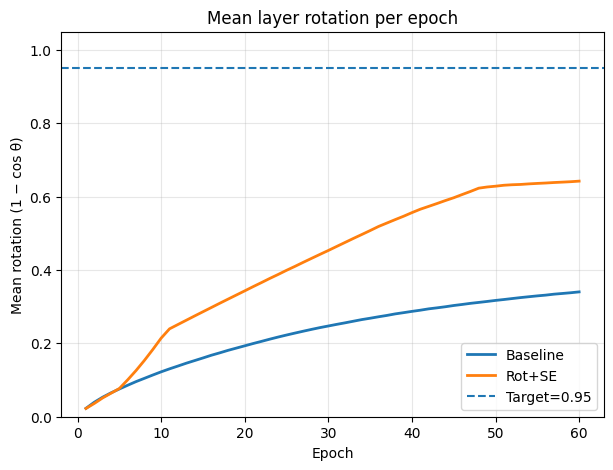

In [51]:
# Plot mean rotation curves
def plot_mean_rotation(base_logs, rot_logs, target=0.95):
    plt.figure(figsize=(7,5))
    plt.plot(base_logs["ep"], base_logs["mean_rot"], label="Baseline", lw=2)
    plt.plot(rot_logs["ep"],  rot_logs["mean_rot"],  label="Rot+SE",  lw=2)
    plt.axhline(target, linestyle="--", linewidth=1.5, label=f"Target={target}")
    plt.ylim(0, 1.05)
    plt.xlabel("Epoch")
    plt.ylabel("Mean rotation (1 − cos θ)")
    plt.title("Mean layer rotation per epoch")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_mean_rotation(base_logs, rot_logs, target=CFG["rot_target"])

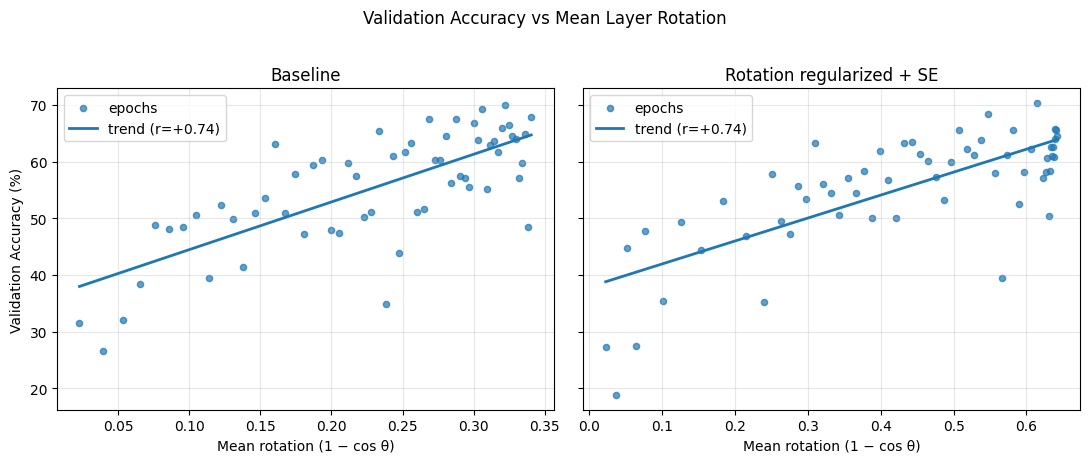

Correlation (Baseline)  meanRot ↔ valAcc: +0.741
Correlation (Rot+SE)   meanRot ↔ valAcc: +0.741


In [52]:
# Scatter: Val Acc vs Mean Rotation (+ correlation)
import numpy as np
import matplotlib.pyplot as plt

def scatter_acc_vs_rotation(base_logs, rot_logs):
    def _prep(logs):
        x = np.array(logs["mean_rot"])
        y = np.array(logs["val_acc"]) * 100.0  # percent
        # handle constant series (avoid NaN corr)
        corr = np.nan
        if x.std() > 0 and y.std() > 0:
            corr = float(np.corrcoef(x, y)[0, 1])
        # simple least-squares line y = a*x + b (only if variation exists)
        if x.std() > 0:
            a, b = np.polyfit(x, y, 1)
        else:
            a, b = 0.0, y.mean()
        return x, y, corr, a, b

    xb, yb, cb, ab, bb = _prep(base_logs)
    xr, yr, cr, ar, br = _prep(rot_logs)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

    # Baseline
    ax = axes[0]
    ax.scatter(xb, yb, s=20, alpha=0.7, label="epochs")
    xs = np.linspace(xb.min(), xb.max() if xb.max()>xb.min() else xb.min()+1e-6, 50)
    ax.plot(xs, ab*xs + bb, linewidth=2, label=f"trend (r={cb:+.2f})")
    ax.set_title("Baseline")
    ax.set_xlabel("Mean rotation (1 − cos θ)")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.grid(True, alpha=0.3); ax.legend()

    # Rot+SE
    ax = axes[1]
    ax.scatter(xr, yr, s=20, alpha=0.7, label="epochs")
    xs = np.linspace(xr.min(), xr.max() if xr.max()>xr.min() else xr.min()+1e-6, 50)
    ax.plot(xs, ar*xs + br, linewidth=2, label=f"trend (r={cr:+.2f})")
    ax.set_title("Rotation regularized + SE")
    ax.set_xlabel("Mean rotation (1 − cos θ)")
    ax.grid(True, alpha=0.3); ax.legend()

    fig.suptitle("Validation Accuracy vs Mean Layer Rotation", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

    print(f"Correlation (Baseline)  meanRot ↔ valAcc: {cb:+.3f}")
    print(f"Correlation (Rot+SE)   meanRot ↔ valAcc: {cr:+.3f}")

# call it
scatter_acc_vs_rotation(base_logs, rot_logs)